In [2]:
import torch
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np
import pandas as pd

from datetime import datetime, timedelta


In [26]:
# Load the Excel file
heatDemand = pd.read_excel('/Users/sorari/Desktop/MSc/project/data/raw/heating_load.xlsx')
heatDemand = heatDemand['Total '].values

coolDemand = 0

netEnergy = heatDemand - coolDemand

weather = pd.read_excel('/Users/sorari/Desktop/MSc/project/data/raw/weather_conditions.xlsx', header=1)
irradiation = weather['Solar radiation (W/m2)'].values # W/m2
Taa = weather['Temp(°C)'].values

carbon = pd.read_csv("/Users/sorari/Desktop/MSc/project/data/raw/df_fuel_ckan.csv")
# Convert the 'DATETIME' column to datetime if it's not already
carbon['DATETIME'] = pd.to_datetime(carbon['DATETIME'])
# Filter the DataFrame for the year 2019
carbon = carbon[carbon['DATETIME'].dt.year == 2019]
# Set the 'DATETIME' column as the index of the DataFrame
carbon.set_index('DATETIME', inplace=True)
# Resample the data to hourly, and take the average of each hour
carbon_hourly = carbon.resample('H').mean()
CO2 = carbon_hourly['CARBON_INTENSITY'].values # g/kWh

# Reshape data to new time resolution
dt = 24  # Time resolution in hours
Horizon = 8760 // dt  # Optimization horizon (hours)
data = np.vstack([netEnergy, irradiation / 1000, CO2, Taa]).T #in kW, kW/m^2, gCO2/kWh, degC
data_r = data.reshape(Horizon, dt, 4).mean(axis=1)

# Extract reshaped data
heat_load_np = data_r[:, 0]        # kW
# cool_load_np = -data_r[:, 0]       # kW
# Set negative demand to zero
# cool_load_np[cool_load_np < 0] = 0  
heat_load_np[heat_load_np < 0] = 0

pv_irradiation_np = data_r[:, 1]   # kW/m^2
pv_irradiation = torch.from_numpy(pv_irradiation_np).to(dtype=torch.float32, device="cpu")  # Specify the device as needed

CO2_intensity = data_r[:, 2] / 1e6  # Scale CO2 intensity to tons
CO2_intensity = torch.from_numpy(CO2_intensity).to(dtype=torch.float32, device="cpu")  # Specify the device as needed

Ta = data_r[:, 3]               # degreeC

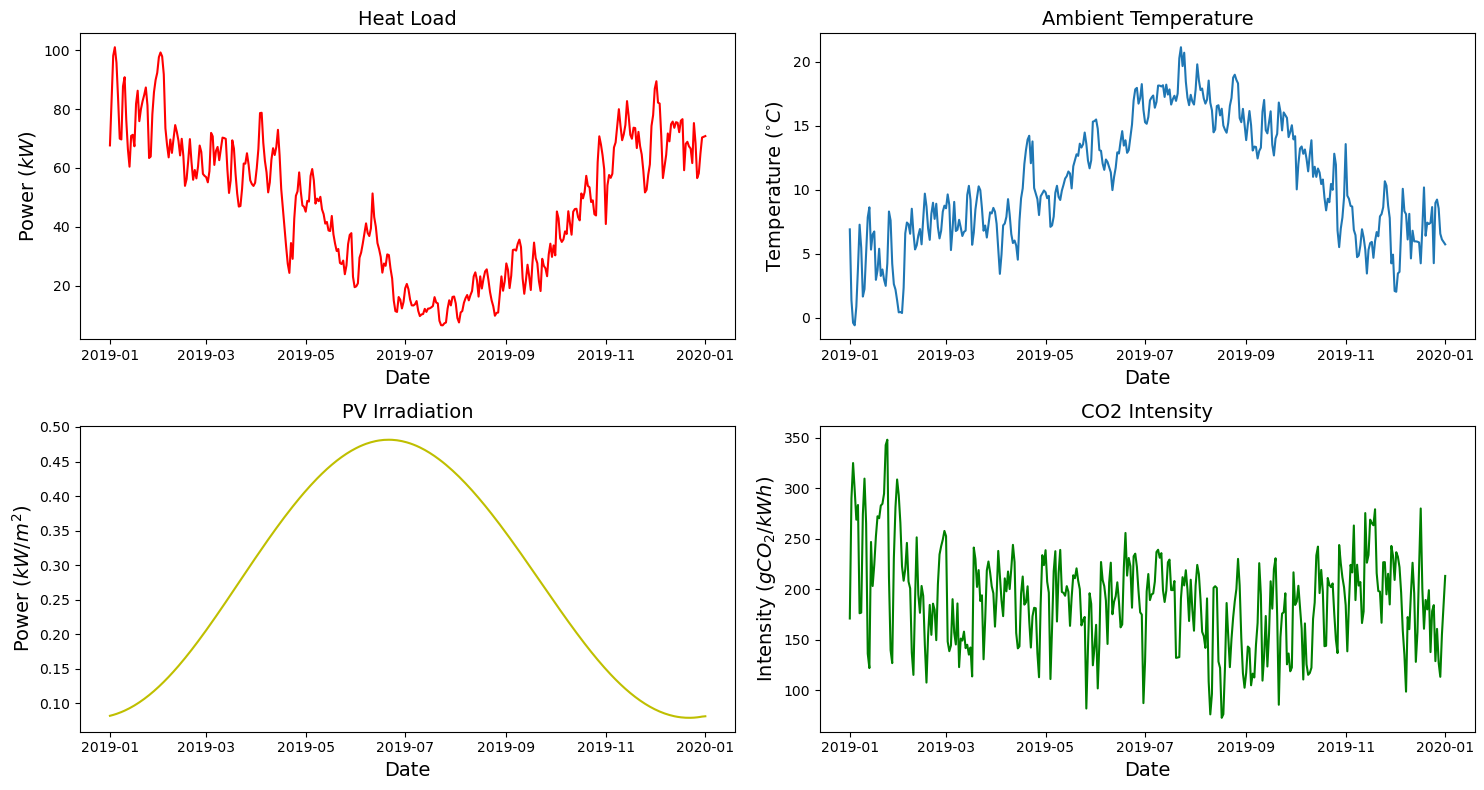

In [27]:
x_plot = np.linspace(0, 365, 365)
# Generate dates from January 1 to December 31
dates = [datetime(2019, 1, 1) + timedelta(days=int(x)) for x in x_plot]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
axes = axes.flatten()

axes[0].plot(dates, heat_load_np, "r-")
axes[0].set_title("Heat Load", fontsize=14)
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel(r"Power $(kW)$", fontsize=14)

axes[1].plot(dates, Ta)
axes[1].set_title("Ambient Temperature", fontsize=14)
axes[1].set_xlabel("Date", fontsize=14)
axes[1].set_ylabel(r"Temperature $(^{\circ}C)$", fontsize=14)

axes[2].plot(dates, pv_irradiation_np, "y-")
axes[2].set_title("PV Irradiation", fontsize=14)
axes[2].set_xlabel("Date", fontsize=14)
axes[2].set_ylabel(r"Power $(kW/m^2)$", fontsize=14)

axes[3].plot(dates, CO2_intensity*1e6, "g-")
axes[3].set_title("CO2 Intensity", fontsize=14)
axes[3].set_xlabel("Date", fontsize=14)
axes[3].set_ylabel(r"Intensity $(gCO_2/kWh)$", fontsize=14)

plt.tight_layout()
plt.show() 

Text(0.5, 1.0, 'Iteration')

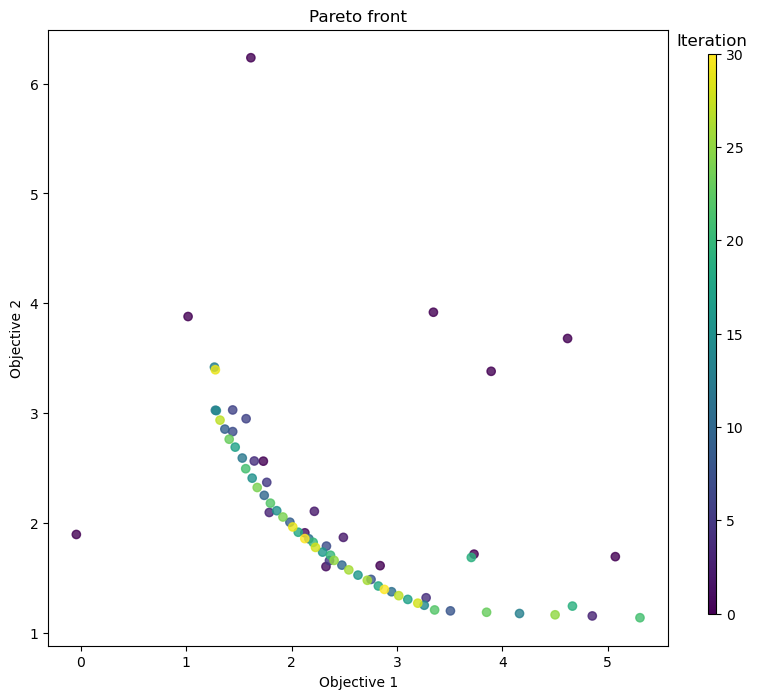

In [366]:
train_obj = -torch.tensor(pd.read_csv('/Users/sorari/Desktop/MSc/project/data/obj_disc.csv').values)

fig, axes = plt.subplots(figsize=(8, 8))
algos = "Pareto front"
cm = plt.get_cmap("viridis")
d = 4
N_BATCH = 30
BATCH_SIZE = 2
batch_number = torch.cat(
    [
        torch.zeros(2 * (d + 1)),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()


sc = axes.scatter(
        train_obj[:, 0].cpu().numpy(),
        train_obj[:, 1].cpu().numpy(),
        c=batch_number,
        alpha=0.8)
axes.set_title(algos)
axes.set_xlabel("Objective 1")
axes.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")


Text(0.5, 1.0, 'Iteration')

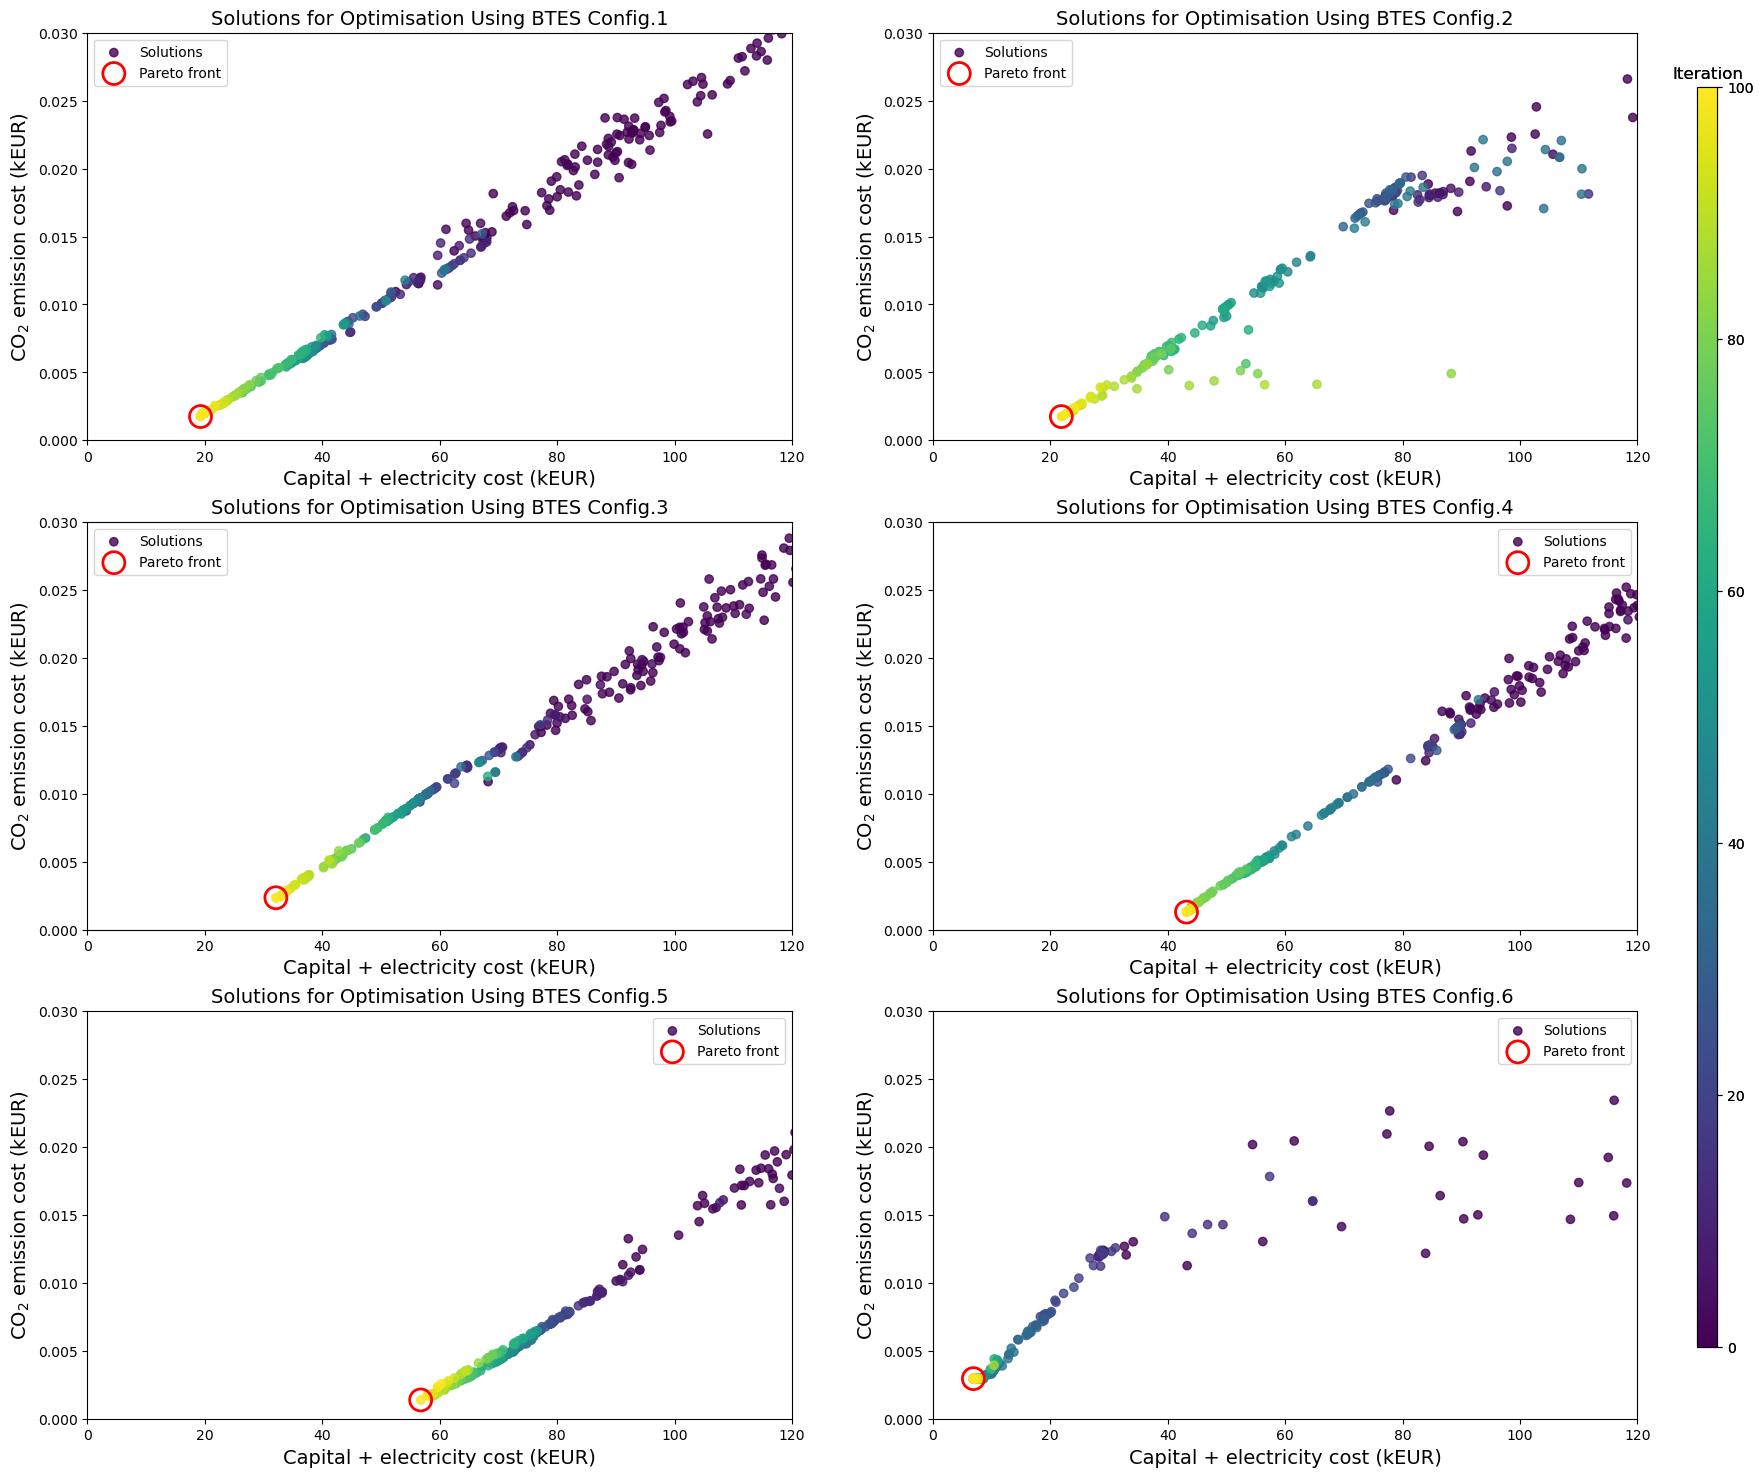

In [172]:
obj_config1 = -torch.tensor(pd.read_csv('/Users/sorari/Desktop/MSc/project/data/obj_config1.csv').values)
obj_config2 = -torch.tensor(pd.read_csv('/Users/sorari/Desktop/MSc/project/data/obj_config2.csv').values)
obj_config3 = -torch.tensor(pd.read_csv('/Users/sorari/Desktop/MSc/project/data/obj_config3.csv').values)
obj_config4 = -torch.tensor(pd.read_csv('/Users/sorari/Desktop/MSc/project/data/obj_config4.csv').values)
obj_config5 = -torch.tensor(pd.read_csv('/Users/sorari/Desktop/MSc/project/data/obj_config5.csv').values)
obj_config6 = -torch.tensor(pd.read_csv('/Users/sorari/Desktop/MSc/project/data/obj_config6.csv').values)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
algos = "Pareto fronts"
cm = plt.get_cmap("viridis")
d = 53
N_BATCH = 100
BATCH_SIZE = 2
batch_number = torch.cat(
    [
        torch.zeros(2 * (d + 1)),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()
axes = axes.flatten()

configs = [obj_config1, obj_config2, obj_config3, obj_config4, obj_config5]
for i, config in enumerate(configs):
    algos = f'Solutions for Optimisation Using BTES Config.{i+1}'
    sc = axes[i].scatter(
        config[:, 0],
        config[:, 1],
        c=batch_number,
        cmap=cm,
        alpha=0.8,
        label='Solutions'
    )
    axes[i].set_title(algos, fontsize=14)
    axes[i].set_xlabel("Capital + electricity cost (kEUR)", fontsize=14)
    axes[i].set_ylabel(r"CO$_2$ emission cost (kEUR)", fontsize=14)
    axes[i].set_xlim(0, 120)
    axes[i].set_ylim(0, 0.03)

    pareto_indices = [min(config[:, 0]).item(), min(config[:, 1]).item()]
    axes[i].scatter(
        pareto_indices[0],
        pareto_indices[1],
        facecolors='none',
        edgecolors='red',
        s=250,  # Size of the circle
        linewidths=2,
        label='Pareto front'
    )
    axes[i].legend()
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=12)
    

d = 31
batch_number = torch.cat(
    [
        torch.zeros(2 * (d + 1)),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()
algos = f'Solutions for Optimisation Using BTES Config.{6}'
sc = axes[5].scatter(
    obj_config6[:, 0],
    obj_config6[:, 1],
    c=batch_number,
    cmap=cm,
    alpha=0.8,
    label='Solutions'
)
axes[5].set_title(algos, fontsize=14)
axes[5].set_xlabel("Capital + electricity cost (kEUR)", fontsize=14)
axes[5].set_ylabel(r"CO$_2$ emission cost (kEUR)", fontsize=14)
axes[5].set_xlim(0, 120)
axes[5].set_ylim(0, 0.03)

pareto_indices = [min(obj_config6[:, 0]).item(), min(obj_config6[:, 1]).item()]
axes[5].scatter(
    pareto_indices[0],
    pareto_indices[1],
    facecolors='none',
    edgecolors='red',
    s=250,  # Size of the circle
    linewidths=2,
    label='Pareto front'
)
axes[5].legend()


norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=12)


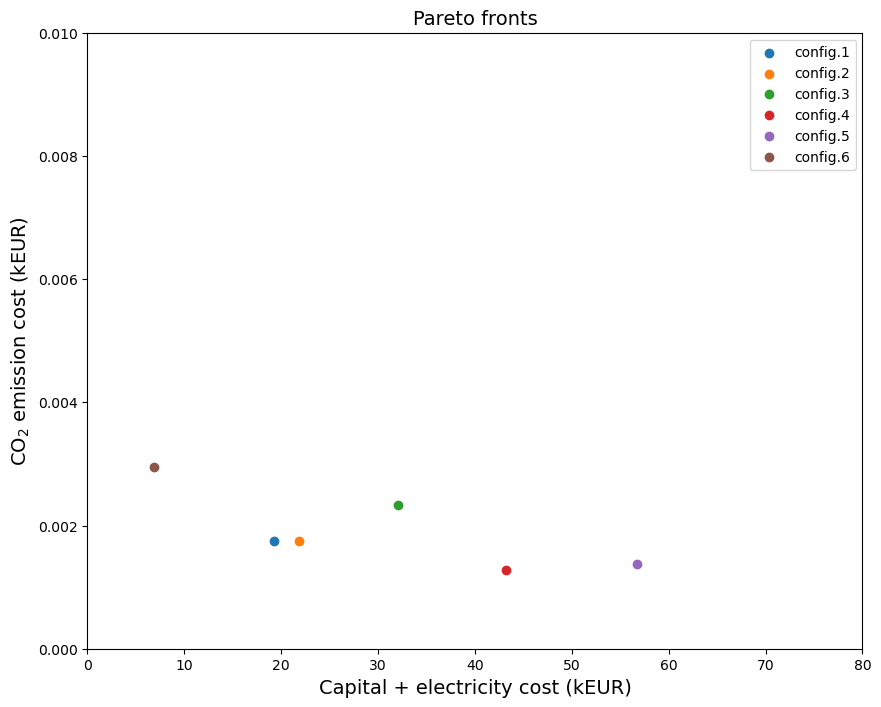

In [173]:
fig, axes = plt.subplots(figsize=(10, 8))
algos = "Pareto fronts"
cm = plt.get_cmap("viridis")

configs = [obj_config1, obj_config2, obj_config3, obj_config4, obj_config5, obj_config6]

for i, config in enumerate(configs):
    pareto_indices = [min(config[:, 0]).item(), min(config[:, 1]).item()]
    axes.scatter(
        pareto_indices[0],
        pareto_indices[1],
        label=f'config.{i+1}'
    )

axes.set_title(algos, fontsize=14)
axes.set_xlabel("Capital + electricity cost (kEUR)", fontsize=14)
axes.set_ylabel(r"CO$_2$ emission cost (kEUR)", fontsize=14)
axes.set_xlim(0, 80)
axes.set_ylim(0, 0.01)
axes.legend()

